## Code for simulating ODE model

In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import scipy.stats
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.integrate import solve_ivp

In [2]:
# ODE model with constant vaccine risk omega
def ode(y, t, o=2e-4, h=0.8, d=3e-4, k=3000):
    s, i, x1, x2 = y
    
    R0 = 16
    gamma = 365/14
    mu = 1/60
    kappa = k
    delta = d
    omega = o
    N1 = 1000
    N2 = 19000
    
    A1 = -omega + i + delta*(2*x1-1 + (1-h)*(2*x2-1))
    A2 = -omega + i + delta*(2*x2-1 + (1-h)*(2*x1-1))
    A3 = -omega + i + delta*(2-h)*(x1+x2-1)
    dydt = [mu*(1-(x1*N1+x2*N2)/(N1+N2)) - R0*(gamma+mu)*s*i - mu*s,
            R0*(gamma+mu)*s*i - (gamma+mu)*i,
            kappa*x1*(1-x1)*A1 + (1-h)*kappa*(x2*(1-x1)*max(A3,0) - (1-x2)*x1*max(-A3,0)),
            kappa*x2*(1-x2)*A2 + (1-h)*kappa*(x1*(1-x2)*max(A3,0) - (1-x1)*x2*max(-A3,0))]
    return dydt

In [3]:
# ODE model with linearly increasing vaccine risk omega
def ode_lin(t, y, h=0.8, d=3e-4, k=3000):
    s, i, x1, x2 = y
    
    R0 = 16
    gamma = 365/14
    mu = 1/60
    kappa = k
    delta = d
    omega = (0.5*t + 2)*1e-4
    N1 = 1000
    N2 = 19000
    
    A1 = -omega + i + delta*(2*x1-1 + (1-h)*(2*x2-1))
    A2 = -omega + i + delta*(2*x2-1 + (1-h)*(2*x1-1))
    A3 = -omega + i + delta*(2-h)*(x1+x2-1)
    dydt = [mu*(1-(x1*N1+x2*N2)/(N1+N2)) - R0*(gamma+mu)*s*i - mu*s,
            R0*(gamma+mu)*s*i - (gamma+mu)*i,
            kappa*x1*(1-x1)*A1 + (1-h)*kappa*(x2*(1-x1)*max(A3,0) - (1-x2)*x1*max(-A3,0)),
            kappa*x2*(1-x2)*A2 + (1-h)*kappa*(x1*(1-x2)*max(A3,0) - (1-x1)*x2*max(-A3,0))]
    return dydt

### Stability of the disease-free uanimously pro-vaccine equilibrium

In [4]:
# For the convenience of demonstration, we use relatively large increments for omega and h
# To see a finer plot, try increasing the following two numbers
num_omega = 60
num_h = 10

X_final_dict = {'omega':[(6/num_omega)*i for i in range(num_omega+1)]}

for i in range(num_h+1):
    o = 0
    h = 1.0 - i*(1/num_h)
    X_final_dict[i] = []
    while o <= 6:
        sol = odeint(ode, [0.01, 1e-6, 0.99, 0.99], np.linspace(0, 25, 10000), args=(o*1e-4, h))
        X_det = (sol[:,2]*1000 + sol[:,3]*19000)/20000
        
        # check the stability of the equilibrium by looking at the trajectory of x
        # if stable, x will converge to 1
        # in unstable, x will diverge away from 1 (to 0)
        if (any(x < X_det[0] for x in X_det)):
            X_final_dict[i].append(0)
        else:
            X_final_dict[i].append(1)
        o += (6/num_omega)

X_final = pd.DataFrame.from_dict(X_final_dict)

/Users/hezitao/opt/anaconda3/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


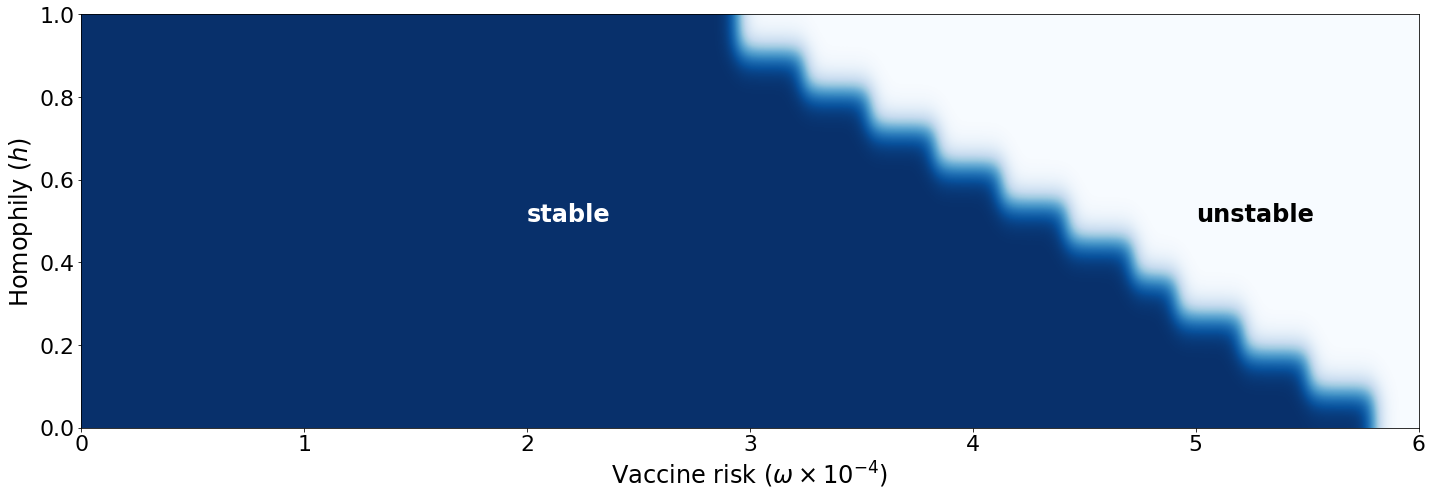

In [5]:
cmap = mpl.colors.LinearSegmentedColormap.from_list('', [plt.cm.Blues(0),plt.cm.Blues(255)])
fig1 = plt.figure(figsize=(20,7))
plt.imshow(X_final[[i for i in range(num_h+1)]].T, cmap='Blues',
           origin='upper', extent=[0,6,0,1], aspect='auto', interpolation='gaussian')
plt.ylabel('Homophily ($h$)', fontsize=24);
plt.xlabel(r'Vaccine risk ($\omega\times 10^{-4}$)', fontsize=24);
plt.yticks(fontsize=22);
plt.xticks(fontsize=22);
plt.text(2, 0.5, 'stable', color='white', fontsize=24, weight='bold');
plt.text(5, 0.5, 'unstable', color='black', fontsize=24, weight='bold');
fig1.tight_layout()

### Realizations of the model

In [6]:
tspan = np.linspace(0, 30, 60000)
yinit = [0.01, 1e-6, 0.99, 0.99]

sol = solve_ivp(lambda t, y: ode_lin(t, y, h=1.0), [tspan[0], tspan[-1]], yinit, t_eval=tspan, rtol = 1e-8)
T_det = sol.t
S_det, I_det, X1_det, X2_det = sol.y[0,:], sol.y[1,:], sol.y[2,:], sol.y[3,:]
X_det = (sol.y[2,:]*1000 + sol.y[3,:]*19000)/20000
df_10 = pd.DataFrame.from_dict({'time':T_det, 'S':S_det, 'I':I_det, 'X1':X1_det, 'X2':X2_det, 'X':X_det})

sol = solve_ivp(lambda t, y: ode_lin(t, y, h=0.8), [tspan[0], tspan[-1]], yinit, t_eval=tspan, rtol = 1e-8)
T_det = sol.t
S_det, I_det, X1_det, X2_det = sol.y[0,:], sol.y[1,:], sol.y[2,:], sol.y[3,:]
X_det = (sol.y[2,:]*1000 + sol.y[3,:]*19000)/20000
df_08 = pd.DataFrame.from_dict({'time':T_det, 'S':S_det, 'I':I_det, 'X1':X1_det, 'X2':X2_det, 'X':X_det})

sol = solve_ivp(lambda t, y: ode_lin(t, y, h=0.6), [tspan[0], tspan[-1]], yinit, t_eval=tspan, rtol = 1e-8)
T_det = sol.t
S_det, I_det, X1_det, X2_det = sol.y[0,:], sol.y[1,:], sol.y[2,:], sol.y[3,:]
X_det = (sol.y[2,:]*1000 + sol.y[3,:]*19000)/20000
df_06 = pd.DataFrame.from_dict({'time':T_det, 'S':S_det, 'I':I_det, 'X1':X1_det, 'X2':X2_det, 'X':X_det})

sol = solve_ivp(lambda t, y: ode_lin(t, y, h=0.4), [tspan[0], tspan[-1]], yinit, t_eval=tspan, rtol = 1e-8)
T_det = sol.t
S_det, I_det, X1_det, X2_det = sol.y[0,:], sol.y[1,:], sol.y[2,:], sol.y[3,:]
X_det = (sol.y[2,:]*1000 + sol.y[3,:]*19000)/20000
df_04 = pd.DataFrame.from_dict({'time':T_det, 'S':S_det, 'I':I_det, 'X1':X1_det, 'X2':X2_det, 'X':X_det})

sol = solve_ivp(lambda t, y: ode_lin(t, y, h=0.2), [tspan[0], tspan[-1]], yinit, t_eval=tspan, rtol = 1e-8)
T_det = sol.t
S_det, I_det, X1_det, X2_det = sol.y[0,:], sol.y[1,:], sol.y[2,:], sol.y[3,:]
X_det = (sol.y[2,:]*1000 + sol.y[3,:]*19000)/20000
df_02 = pd.DataFrame.from_dict({'time':T_det, 'S':S_det, 'I':I_det, 'X1':X1_det, 'X2':X2_det, 'X':X_det})

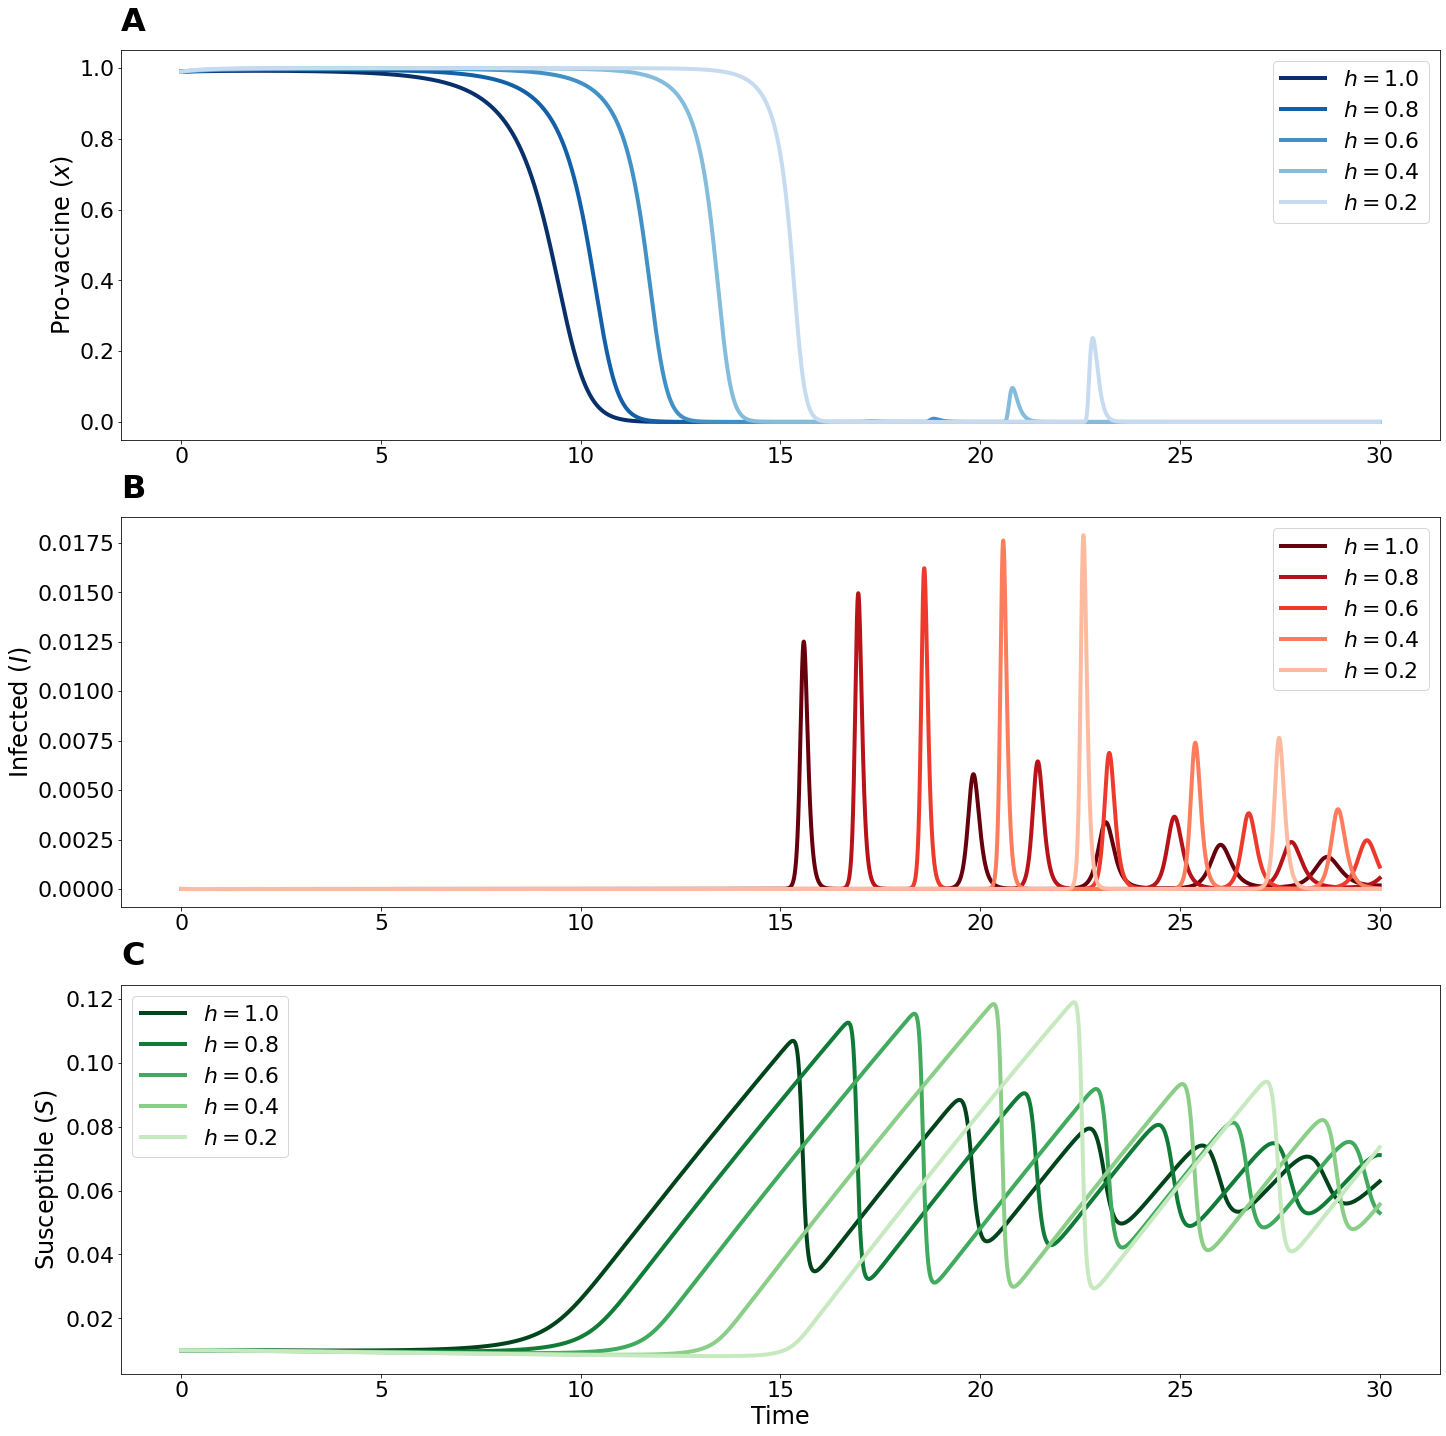

In [7]:
fig2, ax2 = plt.subplots(nrows=3, ncols=1, figsize=(20,20))
ax2[0].plot(df_10['time'], df_10['X'], label='$h=1.0$', linewidth=4, color=plt.cm.Blues(255))
ax2[0].plot(df_08['time'], df_08['X'], label='$h=0.8$', linewidth=4, color=plt.cm.Blues(208))
ax2[0].plot(df_06['time'], df_06['X'], label='$h=0.6$', linewidth=4, color=plt.cm.Blues(160))
ax2[0].plot(df_04['time'], df_04['X'], label='$h=0.4$', linewidth=4, color=plt.cm.Blues(112))
ax2[0].plot(df_02['time'], df_02['X'], label='$h=0.2$', linewidth=4, color=plt.cm.Blues(64))
ax2[0].set_ylabel('Pro-vaccine ($x$)', fontsize=24)
ax2[0].tick_params(axis='both', which='major', labelsize=22)
ax2[0].text(0, 1.05, 'A', transform=ax2[0].transAxes, size=32, weight='bold')
ax2[1].plot(df_10['time'], df_10['I'], label='$h=1.0$', linewidth=4, color=plt.cm.Reds(255))
ax2[1].plot(df_08['time'], df_08['I'], label='$h=0.8$', linewidth=4, color=plt.cm.Reds(208))
ax2[1].plot(df_06['time'], df_06['I'], label='$h=0.6$', linewidth=4, color=plt.cm.Reds(160))
ax2[1].plot(df_04['time'], df_04['I'], label='$h=0.4$', linewidth=4, color=plt.cm.Reds(112))
ax2[1].plot(df_02['time'], df_02['I'], label='$h=0.2$', linewidth=4, color=plt.cm.Reds(64))
ax2[1].set_ylabel('Infected ($I$)', fontsize=24)
ax2[1].tick_params(axis='both', which='major', labelsize=22)
ax2[1].text(0, 1.05, 'B', transform=ax2[1].transAxes, size=32, weight='bold')
ax2[2].plot(df_10['time'], df_10['S'], label='$h=1.0$', linewidth=4, color=plt.cm.Greens(255))
ax2[2].plot(df_08['time'], df_08['S'], label='$h=0.8$', linewidth=4, color=plt.cm.Greens(208))
ax2[2].plot(df_06['time'], df_06['S'], label='$h=0.6$', linewidth=4, color=plt.cm.Greens(160))
ax2[2].plot(df_04['time'], df_04['S'], label='$h=0.4$', linewidth=4, color=plt.cm.Greens(112))
ax2[2].plot(df_02['time'], df_02['S'], label='$h=0.2$', linewidth=4, color=plt.cm.Greens(64))
ax2[2].set_xlabel('Time', fontsize=24)
ax2[2].set_ylabel('Susceptible ($S$)', fontsize=24)
ax2[2].tick_params(axis='both', which='major', labelsize=22)
ax2[2].text(0, 1.05, 'C', transform=ax2[2].transAxes, size=32, weight='bold')
for ax in ax2:
    ax.legend(fontsize=22)

fig2.tight_layout()

### Critical time points and sensitivity analysis

In [8]:
# delta - time of fist epidemic/time of x dropping below 95%
# For the convenience of demonstration, we use relatively large increments for delta
# To see a finer plot, try increasing the following number
num_delta = 50
delta_incr = 5/num_delta

delta_dict_10 = {'delta':[delta_incr*i for i in range(num_delta+1)], 't_thres':[], 't_epi':[]}
delta_dict_08 = {'delta':[delta_incr*i for i in range(num_delta+1)], 't_thres':[], 't_epi':[]}
delta_dict_06 = {'delta':[delta_incr*i for i in range(num_delta+1)], 't_thres':[], 't_epi':[]}
delta_dict_04 = {'delta':[delta_incr*i for i in range(num_delta+1)], 't_thres':[], 't_epi':[]}
delta_dict_02 = {'delta':[delta_incr*i for i in range(num_delta+1)], 't_thres':[], 't_epi':[]}

tspan = np.linspace(0, 50, 50000)
yinit = [0.01, 1e-6, 0.99, 0.99]

for i in range(num_delta+1):
    d10 = delta_dict_10['delta'][i] * 1e-4
    d08 = delta_dict_08['delta'][i] * 1e-4
    d06 = delta_dict_06['delta'][i] * 1e-4
    d04 = delta_dict_04['delta'][i] * 1e-4
    d02 = delta_dict_02['delta'][i] * 1e-4
    
    sol10 = solve_ivp(lambda t, y: ode_lin(t, y, h=1.0, d=d10), [tspan[0], tspan[-1]], yinit, t_eval=tspan, rtol = 1e-5)
    T10 = sol10.t
    S10, I10, X110, X210 = sol10.y[0,:], sol10.y[1,:], sol10.y[2,:], sol10.y[3,:]
    X10 = (sol10.y[2,:]*1000 + sol10.y[3,:]*19000)/20000
    delta_dict_10['t_thres'].append(next(k for k, value in enumerate(list(X10)) if value < 0.95) * 1e-3)
    delta_dict_10['t_epi'].append(next(k for k, value in enumerate(list(I10)) if value > 1e-4) * 1e-3)
    
    sol08 = solve_ivp(lambda t, y: ode_lin(t, y, h=0.8, d=d08), [tspan[0], tspan[-1]], yinit, t_eval=tspan, rtol = 1e-5)
    T08 = sol08.t
    S08, I08, X108, X208 = sol08.y[0,:], sol08.y[1,:], sol08.y[2,:], sol08.y[3,:]
    X08 = (sol08.y[2,:]*1000 + sol08.y[3,:]*19000)/20000
    delta_dict_08['t_thres'].append(next(k for k, value in enumerate(list(X08)) if value < 0.95) * 1e-3)
    delta_dict_08['t_epi'].append(next(k for k, value in enumerate(list(I08)) if value > 1e-4) * 1e-3)
    
    sol06 = solve_ivp(lambda t, y: ode_lin(t, y, h=0.6, d=d06), [tspan[0], tspan[-1]], yinit, t_eval=tspan, rtol = 1e-5)
    T06 = sol06.t
    S06, I06, X106, X206 = sol06.y[0,:], sol06.y[1,:], sol06.y[2,:], sol06.y[3,:]
    X06 = (sol06.y[2,:]*1000 + sol06.y[3,:]*19000)/20000
    delta_dict_06['t_thres'].append(next(k for k, value in enumerate(list(X06)) if value < 0.95) * 1e-3)
    delta_dict_06['t_epi'].append(next(k for k, value in enumerate(list(I06)) if value > 1e-4) * 1e-3)
    
    sol04 = solve_ivp(lambda t, y: ode_lin(t, y, h=0.4, d=d04), [tspan[0], tspan[-1]], yinit, t_eval=tspan, rtol = 1e-5)
    T04 = sol04.t
    S04, I04, X104, X204 = sol04.y[0,:], sol04.y[1,:], sol04.y[2,:], sol04.y[3,:]
    X04 = (sol04.y[2,:]*1000 + sol04.y[3,:]*19000)/20000
    delta_dict_04['t_thres'].append(next(k for k, value in enumerate(list(X04)) if value < 0.95) * 1e-3)
    delta_dict_04['t_epi'].append(next(k for k, value in enumerate(list(I04)) if value > 1e-4) * 1e-3)
    
    sol02 = solve_ivp(lambda t, y: ode_lin(t, y, h=0.2, d=d02), [tspan[0], tspan[-1]], yinit, t_eval=tspan, rtol = 1e-5)
    T02 = sol02.t
    S02, I02, X102, X202 = sol02.y[0,:], sol02.y[1,:], sol02.y[2,:], sol02.y[3,:]
    X02 = (sol02.y[2,:]*1000 + sol02.y[3,:]*19000)/20000
    delta_dict_02['t_thres'].append(next(k for k, value in enumerate(list(X02)) if value < 0.95) * 1e-3)
    delta_dict_02['t_epi'].append(next(k for k, value in enumerate(list(I02)) if value > 1e-4) * 1e-3)

delta_10 = pd.DataFrame.from_dict(delta_dict_10)
delta_08 = pd.DataFrame.from_dict(delta_dict_08)
delta_06 = pd.DataFrame.from_dict(delta_dict_06)
delta_04 = pd.DataFrame.from_dict(delta_dict_04)
delta_02 = pd.DataFrame.from_dict(delta_dict_02)

In [9]:
# kappa - time of fist epidemic/time of x dropping below 95%
# For the convenience of demonstration, we use relatively large increments for kappa
# To see a finer plot, try increasing the following number
num_kappa = 50
kappa_incr = 5/num_kappa

kappa_dict_10 = {'kappa':[2+kappa_incr*i for i in range(num_kappa+1)], 't_thres':[], 't_epi':[]}
kappa_dict_08 = {'kappa':[2+kappa_incr*i for i in range(num_kappa+1)], 't_thres':[], 't_epi':[]}
kappa_dict_06 = {'kappa':[2+kappa_incr*i for i in range(num_kappa+1)], 't_thres':[], 't_epi':[]}
kappa_dict_04 = {'kappa':[2+kappa_incr*i for i in range(num_kappa+1)], 't_thres':[], 't_epi':[]}
kappa_dict_02 = {'kappa':[2+kappa_incr*i for i in range(num_kappa+1)], 't_thres':[], 't_epi':[]}

tspan = np.linspace(0, 50, 50000)
yinit = [0.01, 1e-6, 0.99, 0.99]

for i in range(num_kappa+1):
    k10 = kappa_dict_10['kappa'][i] * 1e3
    k08 = kappa_dict_08['kappa'][i] * 1e3
    k06 = kappa_dict_06['kappa'][i] * 1e3
    k04 = kappa_dict_04['kappa'][i] * 1e3
    k02 = kappa_dict_02['kappa'][i] * 1e3
    
    sol10 = solve_ivp(lambda t, y: ode_lin(t, y, h=1.0, k=k10), [tspan[0], tspan[-1]], yinit, t_eval=tspan, rtol = 1e-5)
    T10 = sol10.t
    S10, I10, X110, X210 = sol10.y[0,:], sol10.y[1,:], sol10.y[2,:], sol10.y[3,:]
    X10 = (sol10.y[2,:]*1000 + sol10.y[3,:]*19000)/20000
    kappa_dict_10['t_thres'].append(next(k for k, value in enumerate(list(X10)) if value < 0.95) * 1e-3)
    kappa_dict_10['t_epi'].append(next(k for k, value in enumerate(list(I10)) if value > 1e-4) * 1e-3)
    
    sol08 = solve_ivp(lambda t, y: ode_lin(t, y, h=0.8, k=k08), [tspan[0], tspan[-1]], yinit, t_eval=tspan, rtol = 1e-5)
    T08 = sol08.t
    S08, I08, X108, X208 = sol08.y[0,:], sol08.y[1,:], sol08.y[2,:], sol08.y[3,:]
    X08 = (sol08.y[2,:]*1000 + sol08.y[3,:]*19000)/20000
    kappa_dict_08['t_thres'].append(next(k for k, value in enumerate(list(X08)) if value < 0.95) * 1e-3)
    kappa_dict_08['t_epi'].append(next(k for k, value in enumerate(list(I08)) if value > 1e-4) * 1e-3)
    
    sol06 = solve_ivp(lambda t, y: ode_lin(t, y, h=0.6, k=k06), [tspan[0], tspan[-1]], yinit, t_eval=tspan, rtol = 1e-5)
    T06 = sol06.t
    S06, I06, X106, X206 = sol06.y[0,:], sol06.y[1,:], sol06.y[2,:], sol06.y[3,:]
    X06 = (sol06.y[2,:]*1000 + sol06.y[3,:]*19000)/20000
    kappa_dict_06['t_thres'].append(next(k for k, value in enumerate(list(X06)) if value < 0.95) * 1e-3)
    kappa_dict_06['t_epi'].append(next(k for k, value in enumerate(list(I06)) if value > 1e-4) * 1e-3)
    
    sol04 = solve_ivp(lambda t, y: ode_lin(t, y, h=0.4, k=k04), [tspan[0], tspan[-1]], yinit, t_eval=tspan, rtol = 1e-5)
    T04 = sol04.t
    S04, I04, X104, X204 = sol04.y[0,:], sol04.y[1,:], sol04.y[2,:], sol04.y[3,:]
    X04 = (sol04.y[2,:]*1000 + sol04.y[3,:]*19000)/20000
    kappa_dict_04['t_thres'].append(next(k for k, value in enumerate(list(X04)) if value < 0.95) * 1e-3)
    kappa_dict_04['t_epi'].append(next(k for k, value in enumerate(list(I04)) if value > 1e-4) * 1e-3)
    
    sol02 = solve_ivp(lambda t, y: ode_lin(t, y, h=0.2, k=k02), [tspan[0], tspan[-1]], yinit, t_eval=tspan, rtol = 1e-5)
    T02 = sol02.t
    S02, I02, X102, X202 = sol02.y[0,:], sol02.y[1,:], sol02.y[2,:], sol02.y[3,:]
    X02 = (sol02.y[2,:]*1000 + sol02.y[3,:]*19000)/20000
    kappa_dict_02['t_thres'].append(next(k for k, value in enumerate(list(X02)) if value < 0.95) * 1e-3)
    kappa_dict_02['t_epi'].append(next(k for k, value in enumerate(list(I02)) if value > 1e-4) * 1e-3)

kappa_10 = pd.DataFrame.from_dict(kappa_dict_10)
kappa_08 = pd.DataFrame.from_dict(kappa_dict_08)
kappa_06 = pd.DataFrame.from_dict(kappa_dict_06)
kappa_04 = pd.DataFrame.from_dict(kappa_dict_04)
kappa_02 = pd.DataFrame.from_dict(kappa_dict_02)

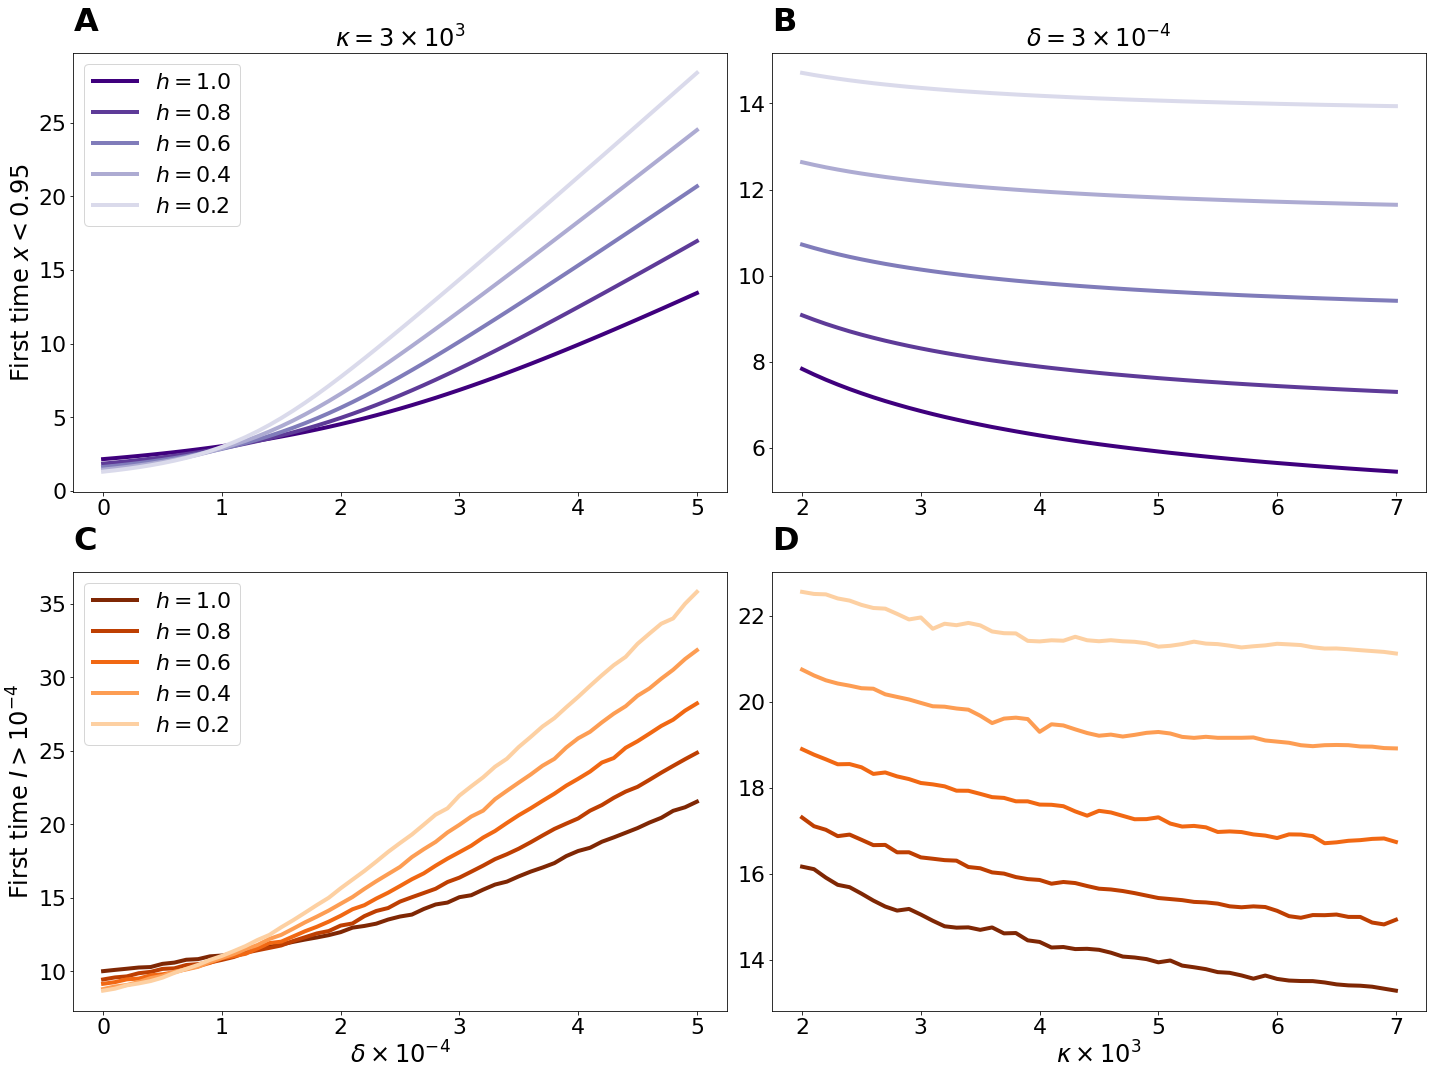

In [10]:
fig3, ax3 = plt.subplots(nrows=2, ncols=2, figsize=(20,15))
ax3[0,0].plot(delta_10['delta'], delta_10['t_thres'], label='$h=1.0$', linewidth=4, color=plt.cm.Purples(255))
ax3[0,0].plot(delta_08['delta'], delta_08['t_thres'], label='$h=0.8$', linewidth=4, color=plt.cm.Purples(208))
ax3[0,0].plot(delta_06['delta'], delta_06['t_thres'], label='$h=0.6$', linewidth=4, color=plt.cm.Purples(160))
ax3[0,0].plot(delta_04['delta'], delta_04['t_thres'], label='$h=0.4$', linewidth=4, color=plt.cm.Purples(112))
ax3[0,0].plot(delta_02['delta'], delta_02['t_thres'], label='$h=0.2$', linewidth=4, color=plt.cm.Purples(64))
ax3[0,0].set_ylabel(r'First time $x<0.95$', fontsize=24)
ax3[0,0].text(0, 1.05, 'A', transform=ax3[0,0].transAxes, size=32, weight='bold')
ax3[0,0].set_title(r'$\kappa=3\times 10^3$', fontsize=24)
ax3[0,0].tick_params(axis='both', which='major', labelsize=22)
ax3[0,0].legend(fontsize=22)
ax3[1,0].plot(delta_10['delta'], delta_10['t_epi'], label='$h=1.0$', linewidth=4, color=plt.cm.Oranges(255))
ax3[1,0].plot(delta_08['delta'], delta_08['t_epi'], label='$h=0.8$', linewidth=4, color=plt.cm.Oranges(208))
ax3[1,0].plot(delta_06['delta'], delta_06['t_epi'], label='$h=0.6$', linewidth=4, color=plt.cm.Oranges(160))
ax3[1,0].plot(delta_04['delta'], delta_04['t_epi'], label='$h=0.4$', linewidth=4, color=plt.cm.Oranges(112))
ax3[1,0].plot(delta_02['delta'], delta_02['t_epi'], label='$h=0.2$', linewidth=4, color=plt.cm.Oranges(64))
ax3[1,0].set_ylabel(r'First time $I>10^{-4}$', fontsize=24)
ax3[1,0].text(0, 1.05, 'C', transform=ax3[1,0].transAxes, size=32, weight='bold')
ax3[1,0].set_xlabel(r'$\delta\times 10^{-4}$', fontsize=24)
ax3[1,0].tick_params(axis='both', which='major', labelsize=22)
ax3[1,0].legend(fontsize=22)

ax3[0,1].plot(kappa_10['kappa'], kappa_10['t_thres'], label='$h=1.0$', linewidth=4, color=plt.cm.Purples(255))
ax3[0,1].plot(kappa_08['kappa'], kappa_08['t_thres'], label='$h=0.8$', linewidth=4, color=plt.cm.Purples(208))
ax3[0,1].plot(kappa_06['kappa'], kappa_06['t_thres'], label='$h=0.6$', linewidth=4, color=plt.cm.Purples(160))
ax3[0,1].plot(kappa_04['kappa'], kappa_04['t_thres'], label='$h=0.4$', linewidth=4, color=plt.cm.Purples(112))
ax3[0,1].plot(kappa_02['kappa'], kappa_02['t_thres'], label='$h=0.2$', linewidth=4, color=plt.cm.Purples(64))
ax3[0,1].text(0, 1.05, 'B', transform=ax3[0,1].transAxes, size=32, weight='bold')
ax3[0,1].set_title(r'$\delta=3\times 10^{-4}$', fontsize=24)
ax3[0,1].tick_params(axis='both', which='major', labelsize=22)
ax3[1,1].plot(kappa_10['kappa'], kappa_10['t_epi'], label='$h=1.0$', linewidth=4, color=plt.cm.Oranges(255))
ax3[1,1].plot(kappa_08['kappa'], kappa_08['t_epi'], label='$h=0.8$', linewidth=4, color=plt.cm.Oranges(208))
ax3[1,1].plot(kappa_06['kappa'], kappa_06['t_epi'], label='$h=0.6$', linewidth=4, color=plt.cm.Oranges(160))
ax3[1,1].plot(kappa_04['kappa'], kappa_04['t_epi'], label='$h=0.4$', linewidth=4, color=plt.cm.Oranges(112))
ax3[1,1].plot(kappa_02['kappa'], kappa_02['t_epi'], label='$h=0.2$', linewidth=4, color=plt.cm.Oranges(64))
ax3[1,1].text(0, 1.05, 'D', transform=ax3[1,1].transAxes, size=32, weight='bold')
ax3[1,1].set_xlabel(r'$\kappa\times 10^3$', fontsize=24)
ax3[1,1].tick_params(axis='both', which='major', labelsize=22)

fig3.tight_layout()

In [11]:
# sensitivity delta
delta_dict_sen = {'delta':[delta_incr*i for i in range(num_delta)],
                  't_thres_10':[], 't_epi_10':[],
                  't_thres_08':[], 't_epi_08':[],
                  't_thres_06':[], 't_epi_06':[],
                  't_thres_04':[], 't_epi_04':[],
                  't_thres_02':[], 't_epi_02':[]}

for i in range(num_delta):
    para_cur = delta_dict_sen['delta'][i] * 1e-4
    
    tt_next = delta_10['t_thres'][i+1]
    tt_cur = delta_10['t_thres'][i]
    tt_sen = (tt_next-tt_cur)/(delta_incr*1e-4) * para_cur/tt_cur
    delta_dict_sen['t_thres_10'].append(tt_sen)
    te_next = delta_10['t_epi'][i+1]
    te_cur = delta_10['t_epi'][i]
    te_sen = (te_next-te_cur)/(delta_incr*1e-4) * para_cur/te_cur
    delta_dict_sen['t_epi_10'].append(te_sen)
    
    tt_next = delta_08['t_thres'][i+1]
    tt_cur = delta_08['t_thres'][i]
    tt_sen = (tt_next-tt_cur)/(delta_incr*1e-4) * para_cur/tt_cur
    delta_dict_sen['t_thres_08'].append(tt_sen)
    te_next = delta_08['t_epi'][i+1]
    te_cur = delta_08['t_epi'][i]
    te_sen = (te_next-te_cur)/(delta_incr*1e-4) * para_cur/te_cur
    delta_dict_sen['t_epi_08'].append(te_sen)
    
    tt_next = delta_06['t_thres'][i+1]
    tt_cur = delta_06['t_thres'][i]
    tt_sen = (tt_next-tt_cur)/(delta_incr*1e-4) * para_cur/tt_cur
    delta_dict_sen['t_thres_06'].append(tt_sen)
    te_next = delta_06['t_epi'][i+1]
    te_cur = delta_06['t_epi'][i]
    te_sen = (te_next-te_cur)/(delta_incr*1e-4) * para_cur/te_cur
    delta_dict_sen['t_epi_06'].append(te_sen)
    
    tt_next = delta_04['t_thres'][i+1]
    tt_cur = delta_04['t_thres'][i]
    tt_sen = (tt_next-tt_cur)/(delta_incr*1e-4) * para_cur/tt_cur
    delta_dict_sen['t_thres_04'].append(tt_sen)
    te_next = delta_04['t_epi'][i+1]
    te_cur = delta_04['t_epi'][i]
    te_sen = (te_next-te_cur)/(delta_incr*1e-4) * para_cur/te_cur
    delta_dict_sen['t_epi_04'].append(te_sen)
    
    tt_next = delta_02['t_thres'][i+1]
    tt_cur = delta_02['t_thres'][i]
    tt_sen = (tt_next-tt_cur)/(delta_incr*1e-4) * para_cur/tt_cur
    delta_dict_sen['t_thres_02'].append(tt_sen)
    te_next = delta_02['t_epi'][i+1]
    te_cur = delta_02['t_epi'][i]
    te_sen = (te_next-te_cur)/(delta_incr*1e-4) * para_cur/te_cur
    delta_dict_sen['t_epi_02'].append(te_sen)

delta_sen = pd.DataFrame.from_dict(delta_dict_sen)

In [12]:
# sensitivity kappa
kappa_dict_sen = {'kappa':[2+kappa_incr*i for i in range(num_kappa)],
                  't_thres_10':[], 't_epi_10':[],
                  't_thres_08':[], 't_epi_08':[],
                  't_thres_06':[], 't_epi_06':[],
                  't_thres_04':[], 't_epi_04':[],
                  't_thres_02':[], 't_epi_02':[]}

for i in range(num_kappa):
    para_cur = kappa_dict_sen['kappa'][i] * 1e3
    
    tt_next = kappa_10['t_thres'][i+1]
    tt_cur = kappa_10['t_thres'][i]
    tt_sen = (tt_next-tt_cur)/(kappa_incr*1e3) * para_cur/tt_cur
    kappa_dict_sen['t_thres_10'].append(tt_sen)
    te_next = kappa_10['t_epi'][i+1]
    te_cur = kappa_10['t_epi'][i]
    te_sen = (te_next-te_cur)/(kappa_incr*1e3) * para_cur/te_cur
    kappa_dict_sen['t_epi_10'].append(te_sen)
    
    tt_next = kappa_08['t_thres'][i+1]
    tt_cur = kappa_08['t_thres'][i]
    tt_sen = (tt_next-tt_cur)/(kappa_incr*1e3) * para_cur/tt_cur
    kappa_dict_sen['t_thres_08'].append(tt_sen)
    te_next = kappa_08['t_epi'][i+1]
    te_cur = kappa_08['t_epi'][i]
    te_sen = (te_next-te_cur)/(kappa_incr*1e3) * para_cur/te_cur
    kappa_dict_sen['t_epi_08'].append(te_sen)
    
    tt_next = kappa_06['t_thres'][i+1]
    tt_cur = kappa_06['t_thres'][i]
    tt_sen = (tt_next-tt_cur)/(kappa_incr*1e3) * para_cur/tt_cur
    kappa_dict_sen['t_thres_06'].append(tt_sen)
    te_next = kappa_06['t_epi'][i+1]
    te_cur = kappa_06['t_epi'][i]
    te_sen = (te_next-te_cur)/(kappa_incr*1e3) * para_cur/te_cur
    kappa_dict_sen['t_epi_06'].append(te_sen)
    
    tt_next = kappa_04['t_thres'][i+1]
    tt_cur = kappa_04['t_thres'][i]
    tt_sen = (tt_next-tt_cur)/(kappa_incr*1e3) * para_cur/tt_cur
    kappa_dict_sen['t_thres_04'].append(tt_sen)
    te_next = kappa_04['t_epi'][i+1]
    te_cur = kappa_04['t_epi'][i]
    te_sen = (te_next-te_cur)/(kappa_incr*1e3) * para_cur/te_cur
    kappa_dict_sen['t_epi_04'].append(te_sen)
    
    tt_next = kappa_02['t_thres'][i+1]
    tt_cur = kappa_02['t_thres'][i]
    tt_sen = (tt_next-tt_cur)/(kappa_incr*1e3) * para_cur/tt_cur
    kappa_dict_sen['t_thres_02'].append(tt_sen)
    te_next = kappa_02['t_epi'][i+1]
    te_cur = kappa_02['t_epi'][i]
    te_sen = (te_next-te_cur)/(kappa_incr*1e3) * para_cur/te_cur
    kappa_dict_sen['t_epi_02'].append(te_sen)

kappa_sen = pd.DataFrame.from_dict(kappa_dict_sen)

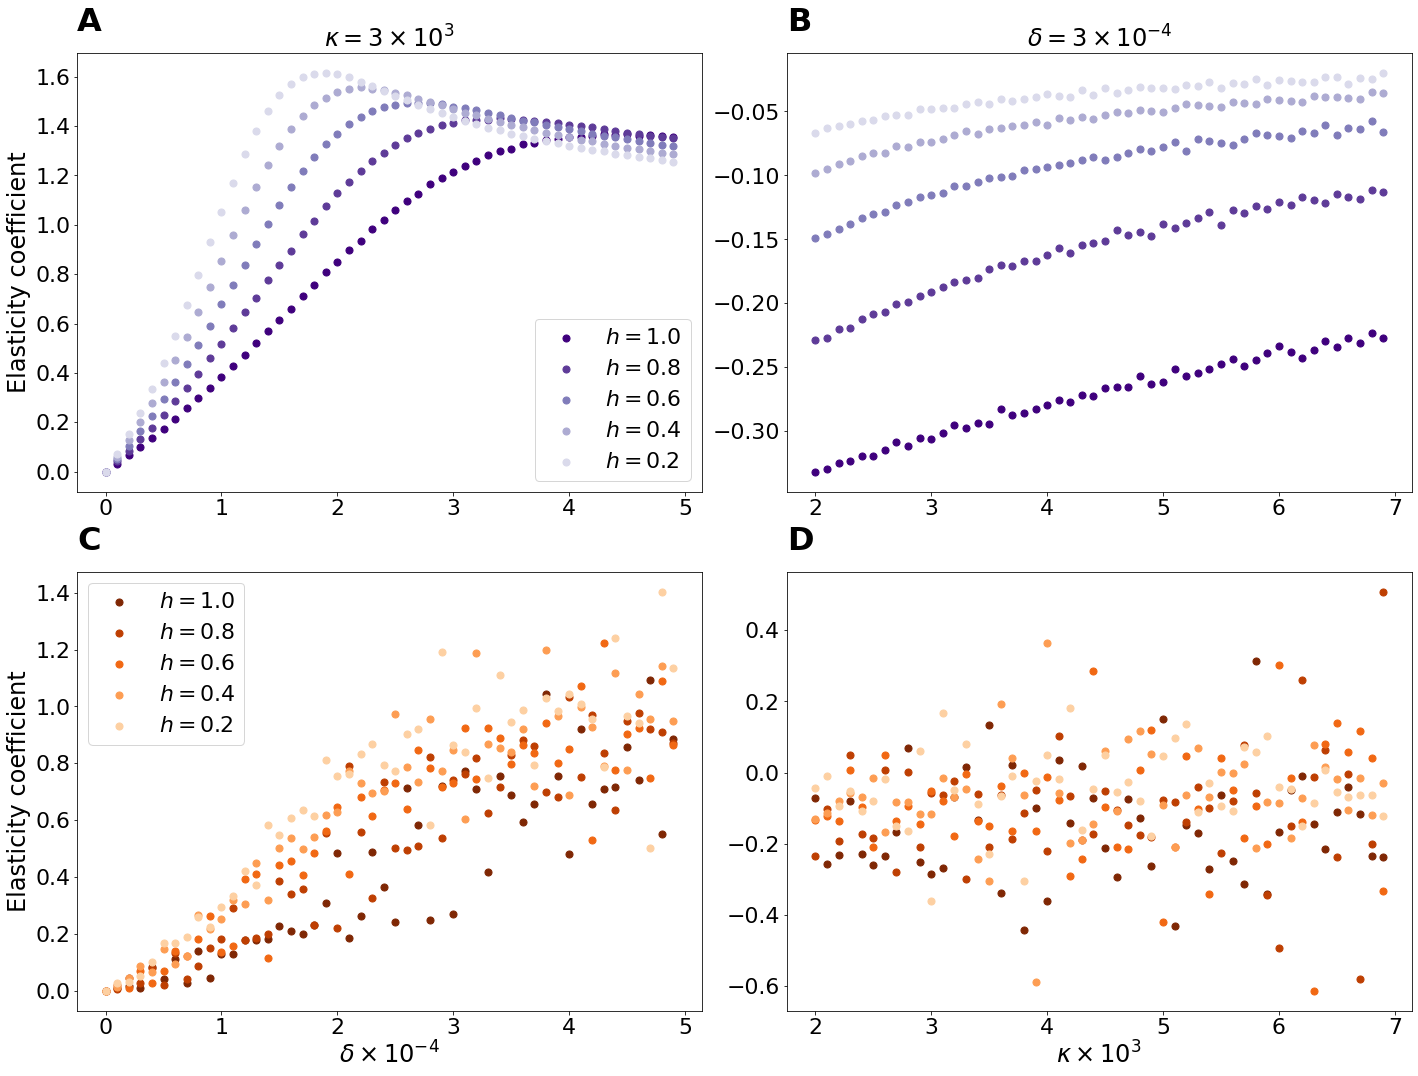

In [13]:
fig4, ax4 = plt.subplots(nrows=2, ncols=2, figsize=(20,15))
ax4[0,0].scatter(delta_sen['delta'], delta_sen['t_thres_10'], label='$h=1.0$', s=50, color=plt.cm.Purples(255))
ax4[0,0].scatter(delta_sen['delta'], delta_sen['t_thres_08'], label='$h=0.8$', s=50, color=plt.cm.Purples(208))
ax4[0,0].scatter(delta_sen['delta'], delta_sen['t_thres_06'], label='$h=0.6$', s=50, color=plt.cm.Purples(160))
ax4[0,0].scatter(delta_sen['delta'], delta_sen['t_thres_04'], label='$h=0.4$', s=50, color=plt.cm.Purples(112))
ax4[0,0].scatter(delta_sen['delta'], delta_sen['t_thres_02'], label='$h=0.2$', s=50, color=plt.cm.Purples(64))
ax4[0,0].set_ylabel('Elasticity coefficient', fontsize=24)
ax4[0,0].set_title(r'$\kappa=3\times 10^3$', fontsize=24)
ax4[0,0].text(0, 1.05, 'A', transform=ax4[0,0].transAxes, size=32, weight='bold')
ax4[0,0].tick_params(axis='both', which='major', labelsize=22)
ax4[0,0].legend(fontsize=22)
ax4[1,0].scatter(delta_sen['delta'], delta_sen['t_epi_10'], label='$h=1.0$', s=50, color=plt.cm.Oranges(255))
ax4[1,0].scatter(delta_sen['delta'], delta_sen['t_epi_08'], label='$h=0.8$', s=50, color=plt.cm.Oranges(208))
ax4[1,0].scatter(delta_sen['delta'], delta_sen['t_epi_06'], label='$h=0.6$', s=50, color=plt.cm.Oranges(160))
ax4[1,0].scatter(delta_sen['delta'], delta_sen['t_epi_04'], label='$h=0.4$', s=50, color=plt.cm.Oranges(112))
ax4[1,0].scatter(delta_sen['delta'], delta_sen['t_epi_02'], label='$h=0.2$', s=50, color=plt.cm.Oranges(64))
ax4[1,0].set_ylabel('Elasticity coefficient', fontsize=24)
ax4[1,0].text(0, 1.05, 'C', transform=ax4[1,0].transAxes, size=32, weight='bold')
ax4[1,0].set_xlabel(r'$\delta\times 10^{-4}$', fontsize=24)
ax4[1,0].tick_params(axis='both', which='major', labelsize=22)
ax4[1,0].legend(fontsize=22)

ax4[0,1].scatter(kappa_sen['kappa'], kappa_sen['t_thres_10'], label='$h=1.0$', s=50, color=plt.cm.Purples(255))
ax4[0,1].scatter(kappa_sen['kappa'], kappa_sen['t_thres_08'], label='$h=0.8$', s=50, color=plt.cm.Purples(208))
ax4[0,1].scatter(kappa_sen['kappa'], kappa_sen['t_thres_06'], label='$h=0.6$', s=50, color=plt.cm.Purples(160))
ax4[0,1].scatter(kappa_sen['kappa'], kappa_sen['t_thres_04'], label='$h=0.4$', s=50, color=plt.cm.Purples(112))
ax4[0,1].scatter(kappa_sen['kappa'], kappa_sen['t_thres_02'], label='$h=0.2$', s=50, color=plt.cm.Purples(64))
ax4[0,1].set_title(r'$\delta=3\times 10^{-4}$', fontsize=24)
ax4[0,1].text(0, 1.05, 'B', transform=ax4[0,1].transAxes, size=32, weight='bold')
ax4[0,1].tick_params(axis='both', which='major', labelsize=22)
ax4[1,1].scatter(kappa_sen['kappa'], kappa_sen['t_epi_10'], label='$h=1.0$', s=50, color=plt.cm.Oranges(255))
ax4[1,1].scatter(kappa_sen['kappa'], kappa_sen['t_epi_08'], label='$h=0.8$', s=50, color=plt.cm.Oranges(208))
ax4[1,1].scatter(kappa_sen['kappa'], kappa_sen['t_epi_06'], label='$h=0.6$', s=50, color=plt.cm.Oranges(160))
ax4[1,1].scatter(kappa_sen['kappa'], kappa_sen['t_epi_04'], label='$h=0.4$', s=50, color=plt.cm.Oranges(112))
ax4[1,1].scatter(kappa_sen['kappa'], kappa_sen['t_epi_02'], label='$h=0.2$', s=50, color=plt.cm.Oranges(64))
ax4[1,1].text(0, 1.05, 'D', transform=ax4[1,1].transAxes, size=32, weight='bold')
ax4[1,1].set_xlabel(r'$\kappa\times 10^3$', fontsize=24)
ax4[1,1].tick_params(axis='both', which='major', labelsize=22)

fig4.tight_layout()

In [14]:
# parameter plane (x < 0.95)
# h in [0, 1], kappa in [2, 7]*1e3, delta in [0, 8]*1e-4
# For the convenience of demonstration, we use relatively large increments for h, delta and kappa
# To see a finer plot, try increasing the following number
num_h = 10
num_kappa = 10
num_delta = 10

h_list = [(1/num_h)*i for i in range(num_h+1)]
kappa_list = [2+(5/num_kappa)*i for i in range(num_kappa+1)]
delta_list = [(7/num_delta)*i for i in range(num_delta+1)]

tspan = np.linspace(0, 50, 50000)
yinit = [0.01, 1e-6, 0.99, 0.99]

In [15]:
h_kappa_dict_thres = {}
delta_kappa_dict_thres = {}
h_delta_dict_thres = {}

for i in range(num_h+1):
    h = h_list[i]
    for j in range(num_kappa+1):
        k = kappa_list[j] * 1e3
        sol = solve_ivp(lambda t, y: ode_lin(t, y, h=h, k=k), [tspan[0], tspan[-1]], yinit, t_eval=tspan, rtol = 1e-5)
        T = sol.t
        S, I, X1, X2 = sol.y[0,:], sol.y[1,:], sol.y[2,:], sol.y[3,:]
        X = (sol.y[2,:]*1000 + sol.y[3,:]*19000)/20000
        
        if i in h_kappa_dict_thres:
            h_kappa_dict_thres[i].append(next(k for k, value in enumerate(list(X)) if value < 0.95) * 1e-3)
        else:
            h_kappa_dict_thres[i] = [next(k for k, value in enumerate(list(X)) if value < 0.95) * 1e-3]

for i in range(num_delta+1):
    d = delta_list[i] * 1e-4
    for j in range(num_kappa+1):
        k = kappa_list[j] * 1e3
        sol = solve_ivp(lambda t, y: ode_lin(t, y, d=d, k=k), [tspan[0], tspan[-1]], yinit, t_eval=tspan, rtol = 1e-5)
        T = sol.t
        S, I, X1, X2 = sol.y[0,:], sol.y[1,:], sol.y[2,:], sol.y[3,:]
        X = (sol.y[2,:]*1000 + sol.y[3,:]*19000)/20000
        
        if i in delta_kappa_dict_thres:
            try:
                delta_kappa_dict_thres[i].append(next(k for k, value in enumerate(list(X)) if value < 0.95) * 1e-3)
            except:
                delta_kappa_dict_thres[i].append(1e3)
        else:
            try:
                delta_kappa_dict_thres[i] = [next(k for k, value in enumerate(list(X)) if value < 0.95) * 1e-3]
            except:
                delta_kappa_dict_thres[i] = [1e3]

for i in range(num_h+1):
    h = h_list[i]
    for j in range(num_delta+1):
        d = delta_list[j] * 1e-4
        sol = solve_ivp(lambda t, y: ode_lin(t, y, h=h, d=d), [tspan[0], tspan[-1]], yinit, t_eval=tspan, rtol = 1e-5)
        T = sol.t
        S, I, X1, X2 = sol.y[0,:], sol.y[1,:], sol.y[2,:], sol.y[3,:]
        X = (sol.y[2,:]*1000 + sol.y[3,:]*19000)/20000
        
        if i in h_delta_dict_thres:
            try:
                h_delta_dict_thres[i].append(next(k for k, value in enumerate(list(X)) if value < 0.95) * 1e-3)
            except:
                h_delta_dict_thres[i].append(1e3)
        else:
            try:
                h_delta_dict_thres[i] = [next(k for k, value in enumerate(list(X)) if value < 0.95) * 1e-3]
            except:
                h_delta_dict_thres[i] = [1e3]

h_kappa_df_thres = pd.DataFrame.from_dict(h_kappa_dict_thres)
delta_kappa_df_thres = pd.DataFrame.from_dict(delta_kappa_dict_thres)
h_delta_df_thres = pd.DataFrame.from_dict(h_delta_dict_thres)

In [16]:
h_kappa_dict_epi = {}
delta_kappa_dict_epi = {}
h_delta_dict_epi = {}

for i in range(num_h+1):
    h = h_list[i]
    for j in range(num_kappa+1):
        k = kappa_list[j] * 1e3
        sol = solve_ivp(lambda t, y: ode_lin(t, y, h=h, k=k), [tspan[0], tspan[-1]], yinit, t_eval=tspan, rtol = 1e-5)
        T = sol.t
        S, I, X1, X2 = sol.y[0,:], sol.y[1,:], sol.y[2,:], sol.y[3,:]
        X = (sol.y[2,:]*1000 + sol.y[3,:]*19000)/20000
        
        if i in h_kappa_dict_epi:
            h_kappa_dict_epi[i].append(next(k for k, value in enumerate(list(I)) if value > 1e-4) * 1e-3)
        else:
            h_kappa_dict_epi[i] = [next(k for k, value in enumerate(list(I)) if value > 1e-4) * 1e-3]

for i in range(num_delta+1):
    d = delta_list[i] * 1e-4
    for j in range(num_kappa+1):
        k = kappa_list[j] * 1e3
        sol = solve_ivp(lambda t, y: ode_lin(t, y, d=d, k=k), [tspan[0], tspan[-1]], yinit, t_eval=tspan, rtol = 1e-5)
        T = sol.t
        S, I, X1, X2 = sol.y[0,:], sol.y[1,:], sol.y[2,:], sol.y[3,:]
        X = (sol.y[2,:]*1000 + sol.y[3,:]*19000)/20000
        
        if i in delta_kappa_dict_epi:
            try:
                delta_kappa_dict_epi[i].append(next(k for k, value in enumerate(list(I)) if value > 1e-4) * 1e-3)
            except:
                delta_kappa_dict_epi[i].append(1e3)
        else:
            try:
                delta_kappa_dict_epi[i] = [next(k for k, value in enumerate(list(I)) if value > 1e-4) * 1e-3]
            except:
                delta_kappa_dict_epi[i] = [1e3]

for i in range(num_h+1):
    h = h_list[i]
    for j in range(num_delta+1):
        d = delta_list[j] * 1e-4
        sol = solve_ivp(lambda t, y: ode_lin(t, y, h=h, d=d), [tspan[0], tspan[-1]], yinit, t_eval=tspan, rtol = 1e-5)
        T = sol.t
        S, I, X1, X2 = sol.y[0,:], sol.y[1,:], sol.y[2,:], sol.y[3,:]
        X = (sol.y[2,:]*1000 + sol.y[3,:]*19000)/20000
        
        if i in h_delta_dict_epi:
            try:
                h_delta_dict_epi[i].append(next(k for k, value in enumerate(list(I)) if value > 1e-4) * 1e-3)
            except:
                h_delta_dict_epi[i].append(1e3)
        else:
            try:
                h_delta_dict_epi[i] = [next(k for k, value in enumerate(list(I)) if value > 1e-4) * 1e-3]
            except:
                h_delta_dict_epi[i] = [1e3]

h_kappa_df_epi = pd.DataFrame.from_dict(h_kappa_dict_epi)
delta_kappa_df_epi = pd.DataFrame.from_dict(delta_kappa_dict_epi)
h_delta_df_epi = pd.DataFrame.from_dict(h_delta_dict_epi)

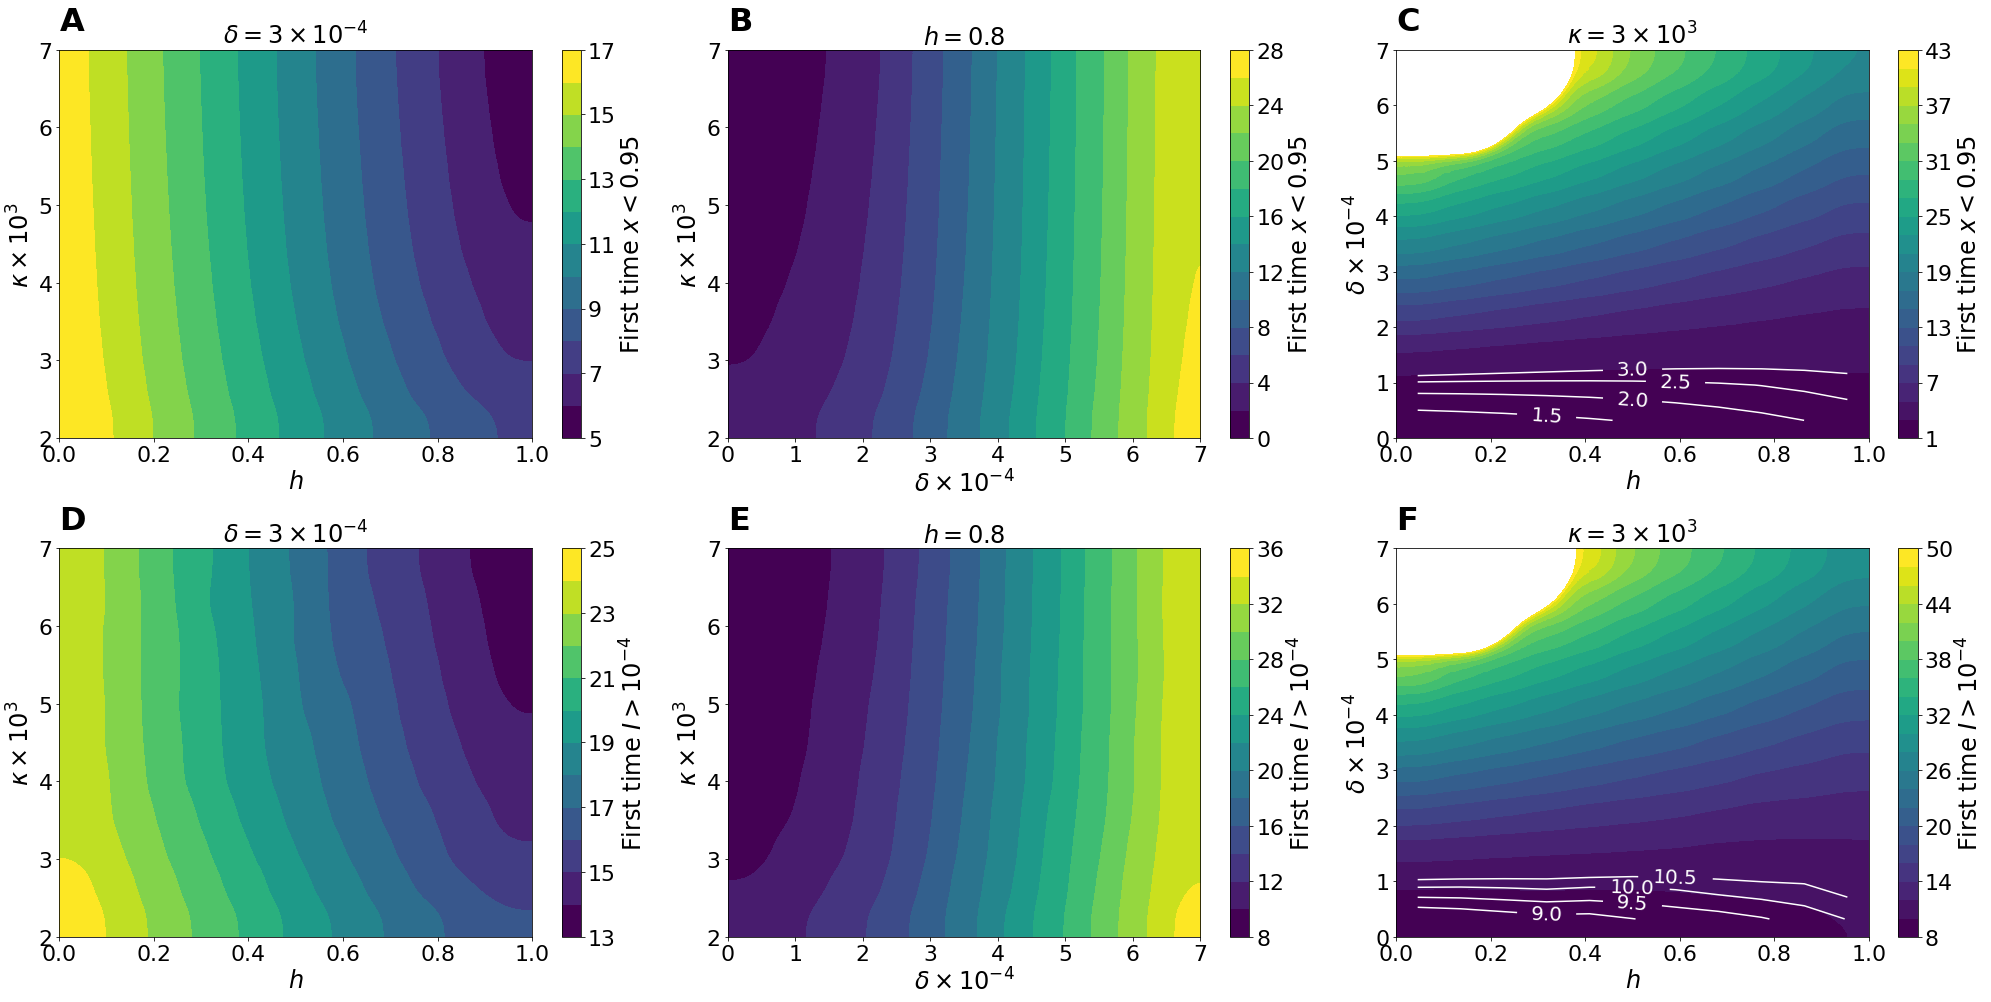

In [17]:
import copy

fig5 = plt.figure(figsize=(28,14))
cmap = copy.copy(mpl.cm.get_cmap('viridis'))
cmap.set_over(color='white')

sp1 = plt.subplot(231)
norm = mpl.colors.BoundaryNorm(np.arange(5, 18, 1), cmap.N)
plt.imshow(h_kappa_df_thres, origin='lower', extent=[0,1.0,2.0,7.0], aspect='auto', cmap=cmap, norm=norm, interpolation='gaussian')
plt.title(r'$\delta=3\times 10^{-4}$', fontsize=24)
plt.xlabel('$h$', fontsize=24)
plt.ylabel(r'$\kappa\times 10^3$', fontsize=24)
cbar1 = plt.colorbar()
cbar1.ax.set_ylabel(ylabel=r'First time $x<0.95$', fontsize=24)
cbar1.ax.tick_params(labelsize=22)
plt.text(0, 1.05, 'A', transform=sp1.transAxes, size=32, weight='bold')
plt.tick_params(axis='both', which='major', labelsize=22)

sp2 = plt.subplot(232)
norm = mpl.colors.BoundaryNorm(np.arange(0, 30, 2), cmap.N)
plt.imshow(delta_kappa_df_thres, origin='lower', extent=[0,7.0,2.0,7.0], aspect='auto', cmap=cmap, norm=norm, interpolation='gaussian')
plt.title('$h=0.8$', fontsize=24)
plt.xlabel(r'$\delta\times 10^{-4}$', fontsize=24)
plt.ylabel(r'$\kappa\times 10^3$', fontsize=24)
cbar2 = plt.colorbar()
cbar2.ax.set_ylabel(ylabel=r'First time $x<0.95$', fontsize=24)
cbar2.ax.tick_params(labelsize=22)
plt.text(0, 1.05, 'B', transform=sp2.transAxes, size=32, weight='bold')
plt.tick_params(axis='both', which='major', labelsize=22)

sp3 = plt.subplot(233)
norm = mpl.colors.BoundaryNorm(np.arange(1, 44, 2), cmap.N)
plt.imshow(h_delta_df_thres, origin='lower', extent=[0,1.0,0,7.0], aspect='auto', cmap=cmap, norm=norm, interpolation='gaussian')
plt.title(r'$\kappa=3\times 10^3$', fontsize=24)
plt.xlabel('$h$', fontsize=24)
plt.ylabel(r'$\delta\times 10^{-4}$', fontsize=24)
cbar3 = plt.colorbar()
cbar3.ax.set_ylabel(ylabel=r'First time $x<0.95$', fontsize=24)
cbar3.ax.tick_params(labelsize=22)
plt.text(0, 1.05, 'C', transform=sp3.transAxes, size=32, weight='bold')
plt.tick_params(axis='both', which='major', labelsize=22)
CS = plt.contour(h_delta_df_thres, levels=[1.5, 2, 2.5, 3], origin='lower', extent=[0,1.0,0,7.0], colors=['white','white','white','white'])
plt.clabel(CS, inline=True, fmt='%1.1f', fontsize=20)

sp4 = plt.subplot(234)
norm = mpl.colors.BoundaryNorm(np.arange(13, 26, 1), cmap.N)
plt.imshow(h_kappa_df_epi, origin='lower', extent=[0,1.0,2.0,7.0], aspect='auto', cmap=cmap, norm=norm, interpolation='gaussian')
plt.title(r'$\delta=3\times 10^{-4}$', fontsize=24)
plt.xlabel('$h$', fontsize=24)
plt.ylabel(r'$\kappa\times 10^3$', fontsize=24)
cbar4 = plt.colorbar()
cbar4.ax.set_ylabel(ylabel=r'First time $I>10^{-4}$', fontsize=24)
cbar4.ax.tick_params(labelsize=22)
plt.text(0, 1.05, 'D', transform=sp4.transAxes, size=32, weight='bold')
plt.tick_params(axis='both', which='major', labelsize=22)

sp5 = plt.subplot(235)
norm = mpl.colors.BoundaryNorm(np.arange(8, 38, 2), cmap.N)
plt.imshow(delta_kappa_df_epi, origin='lower', extent=[0,7.0,2.0,7.0], aspect='auto', cmap=cmap, norm=norm, interpolation='gaussian')
plt.title('$h=0.8$', fontsize=24)
plt.xlabel(r'$\delta\times 10^{-4}$', fontsize=24)
plt.ylabel(r'$\kappa\times 10^3$', fontsize=24)
cbar5 = plt.colorbar()
cbar5.ax.set_ylabel(ylabel=r'First time $I>10^{-4}$', fontsize=24)
cbar5.ax.tick_params(labelsize=22)
plt.text(0, 1.05, 'E', transform=sp5.transAxes, size=32, weight='bold')
plt.tick_params(axis='both', which='major', labelsize=22)

sp6 = plt.subplot(236)
norm = mpl.colors.BoundaryNorm(np.arange(8, 52, 2), cmap.N)
plt.imshow(h_delta_df_epi, origin='lower', extent=[0,1.0,0,7.0], aspect='auto', cmap=cmap, norm=norm, interpolation='gaussian')
plt.title(r'$\kappa=3\times 10^3$', fontsize=24)
plt.xlabel('$h$', fontsize=24)
plt.ylabel(r'$\delta\times 10^{-4}$', fontsize=24)
cbar6 = plt.colorbar()
cbar6.ax.set_ylabel(ylabel=r'First time $I>10^{-4}$', fontsize=24)
cbar6.ax.tick_params(labelsize=22)
plt.text(0, 1.05, 'F', transform=sp6.transAxes, size=32, weight='bold')
plt.tick_params(axis='both', which='major', labelsize=22)
CS = plt.contour(h_delta_df_epi, levels=[9, 9.5, 10, 10.5], origin='lower', extent=[0,1.0,0,7.0], colors=['white','white','white','white'])
plt.clabel(CS, inline=True, fmt='%1.1f', fontsize=20)

fig5.tight_layout()